# 1. Introduction

When it comes to predicition the health of a structure, or Strucutural Health Monitoring (SHM), the identification of data features that allows one to distinguish between undamaged and damaged states is one of the most important parts. Low-dimensional feature set that is highly sensitive to the condition would allow simple and effective machine learning models to predict a structure condition. For this bearing problem, we are going to apply a very efficient signal processing technique. 

In [1]:
import scipy
from scipy import io
import numpy as np
import pandas as pd 

import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from statsmodels.tsa.ar_model import AutoReg
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier as DTC

from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

In [2]:
custom_plot = {'font.serif':'Computer Modern Roman',
               'font.size': 18, 
               'text.usetex': False,
               'axes.grid.which': 'both',
               'axes.grid': True,
               'grid.linestyle': '--',
               'xtick.minor.visible':True,
               'ytick.minor.visible':True,
               'ytick.minor.size':4,
               'ytick.major.size':10,
               'lines.markersize': 10.0,
              }

mpl.rcParams.update(custom_plot)

# 2. Loading and Preparing Data

In other to a classify the health condition of a bearing, we import the data and create instances from them. The idea is to separate the signal of a condition into batches of data that will be processed and have their feature extracted. A much more realiable approach than applying the algorithm directly to the raw data.

In [3]:
file = "../input/engine-acoustic-emissions/dataset.mat"
dataset = scipy.io.loadmat(file)

df_normal = dataset["normal"].reshape(-1)
df_inner = dataset["inner"].reshape(-1)
df_roller = dataset["roller"].reshape(-1)
df_outer = dataset["outer"].reshape(-1)

data = [df_normal,df_inner,df_roller,df_outer]
label = ['normal', 'inner', 'roller', 'outer']

label_dic = {0: 'normal',
             1: 'inner',
             2: 'roller',
             3: 'outer'}

frequency = 10000


A instance will be considered as 0.2 seconds of the record, therefore, for each health condition, there will be 60 instances.

In [4]:
def instancing_data(train_size = 0.7, sample_duration = 0.2):
    
    df_test = pd.DataFrame(columns=('signal', 'label', 'instance'))
    df_train = df_test.copy()
    
    for j, arr in enumerate(data):
        
        size = arr.size
        samples = sample_duration * frequency
        n_instances = size / samples
        
        if n_instances > int(n_instances):
            n_instances += 1
        
        samples = int(samples)
        n_instances = int(n_instances)
        
        for i in range(n_instances):
            signal = arr[0+samples*i:samples*(i+1)]
            df_aux = pd.DataFrame({'signal': signal, 'label': j, 'instance': i + n_instances * j})
            
            if i < n_instances * train_size:
                
                df_train = df_train.append(df_aux, ignore_index = True)
            
            else:
                df_test = df_test.append(df_aux, ignore_index = True)
    
    return df_train, df_test

In [5]:
df_train, df_test = instancing_data()

# 3. AutoRegressive Model

The ideia behind Autoregressive feature extraction is to train a model to a health structure, apply to a unkown condition, and then compare the model results. If the structure is healthy, the errors will be similar, if not, they will differ, as we can see in the example below:

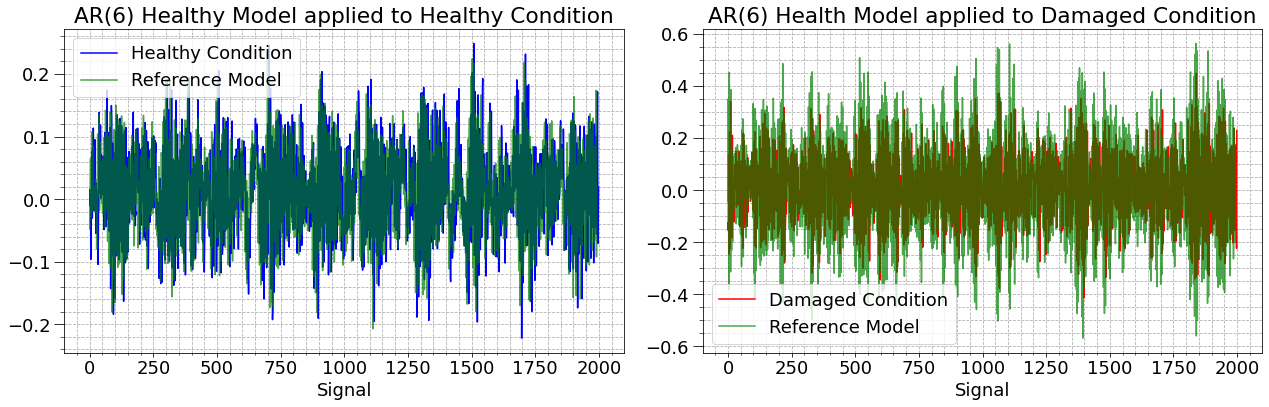

In [6]:
xtb = df_train.loc[df_train['instance'] == 0, 'signal'].to_numpy()
xth = df_train.loc[df_train['instance'] == 10, 'signal'].to_numpy()
xtd = df_train.loc[df_train['instance'] == 153, 'signal'].to_numpy()

ar = 6

model = AutoReg(xtb, ar, old_names = False).fit()

params = model.params[1:]
bias = model.params[0]

xth_pred = np.sum([xth[k:xth.size-ar+k] * p for k, p in enumerate(params[::-1])], axis = 0) + bias
xtd_pred = np.sum([xtd[k:xtd.size-ar+k] * p for k, p in enumerate(params[::-1])], axis = 0) + bias

fig, ax = plt.subplots(1, 2, figsize= (18, 6))

ax[0].plot(xth, color = 'b', label = 'Healthy Condition')
ax[0].plot(xth_pred, label = 'Reference Model', color = 'g', alpha = 0.7);
ax[0].set_title(f'AR({ar}) Healthy Model applied to Healthy Condition')

ax[1].plot(xtd, color = 'r', label = 'Damaged Condition')
ax[1].plot(xtd_pred, label = 'Reference Model', color = 'g', alpha = 0.7);
ax[1].set_title(f'AR({ar}) Health Model applied to Damaged Condition')

ax[0].legend()
ax[1].legend();

ax[0].set_xlabel('Signal')
ax[1].set_xlabel('Signal')

fig.tight_layout();

We can see a better agreement of the signal and the predictions in the first figure, mostly because they belong to the same health condition (healthy). To select the Autoregressive Lag, the AIC Score is evaluated, selecting a reasonable value were the AIC Score is considerably small.

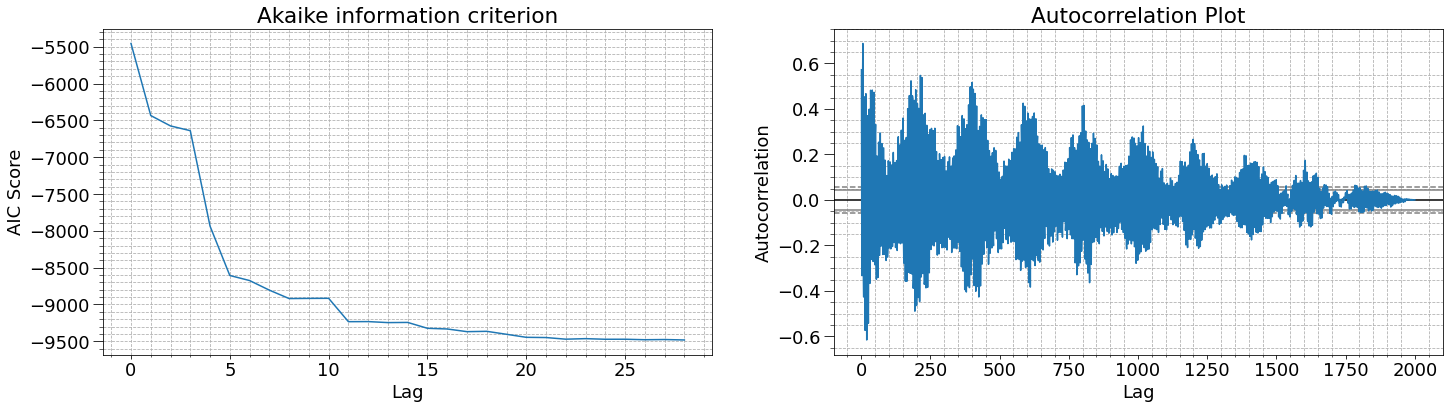

In [7]:
xt = df_train.loc[df_train['instance'] == 0, 'signal']
AIC = []

for i in range(1, 30):
    model = AutoReg(xt.to_numpy(), i, old_names = False)
    res = model.fit()
    AIC.append(res.aic)

fig, ax = plt.subplots(1, 2, figsize=(24, 6))
ax[0].plot(AIC)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('AIC Score')
ax[0].set_title('Akaike information criterion')

pd.plotting.autocorrelation_plot(xt, ax=ax[1])
ax[1].set_title('Autocorrelation Plot');

The AR degree selected is 11.

# 4. Feature Extraction

There are two features to extract from a Autoregressive model, compare the error variance of the signals or their coeficient variance. Let's extract both.

In [8]:
def feature_extraction(df, xtb, ar = 11):
    
    er_model = AutoReg(xtb.to_numpy(), ar, old_names = False).fit()
    
    instances = df['instance'].unique()
    
    n_instances = instances.size
    
    var_er_pred = np.var(er_model.resid)
    var_er_coef = np.var(er_model.params)
    
    gamma1 = []
    gamma2 = []
    label = []
    
    for i in range(n_instances):
        xt = df.loc[df['instance'] == instances[i], 'signal']
        ei_model = AutoReg(xt.to_numpy(), ar, old_names = False).fit()
        
        params = er_model.params[1:]
        bias = er_model.params[0]
        xtp = np.sum([xt[k:xt.size-ar+k] * p for k, p in enumerate(params[::-1])], axis = 0) + bias
        
        var_ei_pred = np.var(xt[ar:]-xtp)
        var_ei_coef = np.var(ei_model.params)
        
        gamma1.append(var_ei_pred/var_er_pred)
        gamma2.append(var_ei_coef/var_er_coef)
        label.append(df.loc[df['instance'] == instances[i], 'label'].iat[0])
    
    df_result = pd.DataFrame({'instance': range(n_instances), 'g1': gamma1, 'g2': gamma2, 'label': label})
    
    return df_result

In [9]:
df_train_ex = feature_extraction(df_train, df_train.loc[df_train['instance'] == 0, 'signal'])

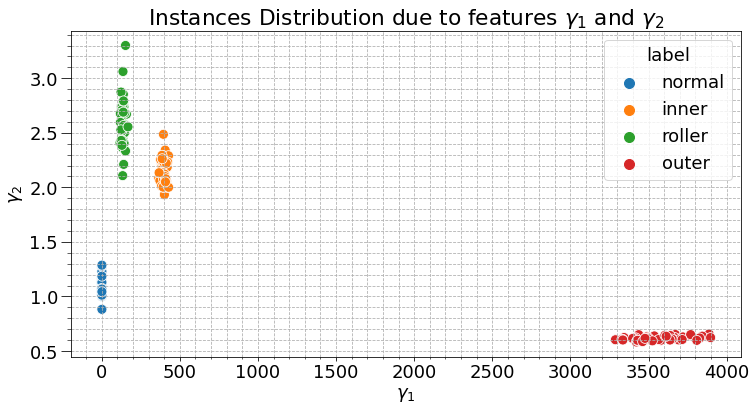

In [10]:
df_aux = df_train_ex.replace({'label': label_dic})

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title('Instances Distribution due to features $\gamma_1$ and $\gamma_2$')
sns.scatterplot(data=df_aux, x='g1', y = 'g2', hue='label', ax=ax)
ax.set_xlabel('$\gamma_1$')
ax.set_ylabel('$\gamma_2$');

We can definitely see distincts groups of data.

# 5. Training Model

In order to classify the conditions, we are going to use a simple Decision Tree Model with max depth of 2.

In [11]:
X_train = df_train_ex[['g1', 'g2']]
y_train = df_train_ex['label']

In [12]:
model = DTC(max_depth=2)
model.fit(X_train.to_numpy(), y_train)

DecisionTreeClassifier(max_depth=2)

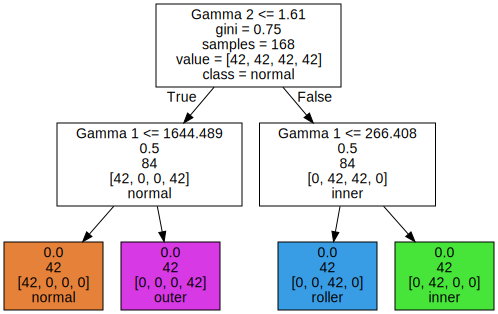

In [13]:
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names= ['Gamma 1', 'Gamma 2'],  
                                class_names=label,
                                label='root',
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

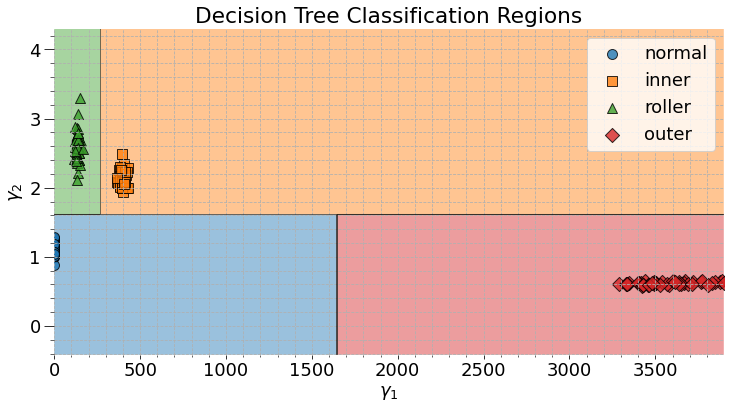

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title('Decision Tree Classification Regions')
plot_decision_regions(X_train.to_numpy(), y_train.to_numpy(), 
                      clf=model, markers = ('o', 's', '^', 'D'),
                      ax=ax,
                     )
ax.set_xlabel('$\gamma_1$')
ax.set_ylabel('$\gamma_2$');
L=ax.legend()
for i in range(4):
    L.get_texts()[i].set_text(label[i])

In [15]:
df_test_ex = feature_extraction(df_test, df_train.loc[df_train['instance'] == 0, 'signal'])
X_test = df_test_ex[['g1', 'g2']].to_numpy()
y_test = df_test_ex['label']

y_pred = model.predict(X_test)

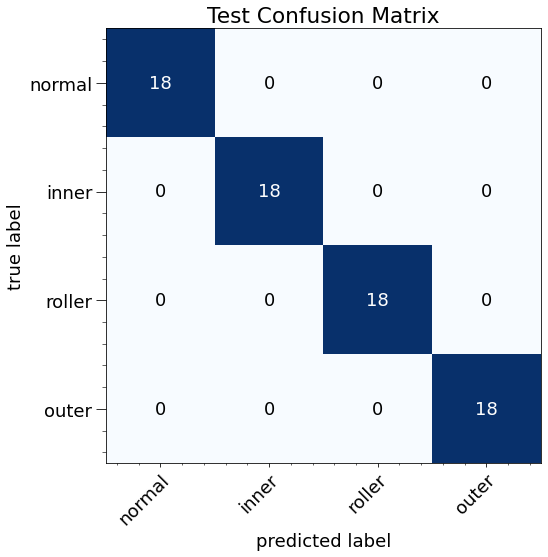

In [16]:
mpl.rcParams.update({'axes.grid': False})

cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(cm, figsize=(8, 8), class_names=label)
ax.set_title('Test Confusion Matrix');

The model was able to classify all the test data correctly.

# 6. Evaluate Sample Duration 

You might be wondering, how smaller my instance can be in other to predict the health condition of my structure? To put as a implementation problem, how fast can I predict the damage of a structure? For this question, we can go with two approaches: predicting if the damage happened or predict which damage happened in the structure. The F1 Score will be our metric, since the healthy condition has less examples than the damaged conditions. 

In [ ]:
model = DTC(max_depth=2)

sample_durations = [0.2, 0.1, 0.05, 0.02, 0.01]

class_scores = []
binary_scores = []

for sd in sample_durations:
    df_train, df_test = instancing_data(sample_duration = sd)
    
    df_train_ex = feature_extraction(df_train, df_train.loc[df_train['instance'] == 0, 'signal'])
    X_train = df_train_ex[['g1', 'g2']].to_numpy()
    y_train = df_train_ex['label']
    
    df_test_ex = feature_extraction(df_test, df_train.loc[df_train['instance'] == 0, 'signal'])
    X_test = df_test_ex[['g1', 'g2']].to_numpy()
    y_test = df_test_ex['label']
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    y_test_bin = y_test.copy()
    y_pred_bin = y_pred.copy()
    
    y_test_bin[y_test_bin > 0] = 1
    y_pred_bin[y_pred_bin > 0] = 1
    
    
    f1 = f1_score(y_test, y_pred, average = 'macro')
    f1_bin = f1_score(y_test_bin, y_pred_bin)
    
    class_scores.append(f1)
    binary_scores.append(f1_bin)
    print(f'Sample Duration: {sd}\nCondition Classification Score: {f1:.2f}\nDamage Classification Score: {f1_bin:.2f}\n')
    

Sample Duration: 0.2
Condition Classification Score: 1.00
Damage Classification Score: 1.00

Sample Duration: 0.1
Condition Classification Score: 0.99
Damage Classification Score: 1.00

Sample Duration: 0.05
Condition Classification Score: 1.00
Damage Classification Score: 1.00



In [ ]:
mpl.rcParams.update({'axes.grid': True})

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(sample_durations, class_scores, ls = '-', marker = 'o', color='b', label = 'Condition Classification')
ax.plot(sample_durations, binary_scores, ls = '--', marker = 'o', color='r', label = 'Health Classification')
ax.set_xlabel('Sample Duration [s]')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score due to Sample Duration')
ax.legend();

There is no condition missclassifications until 0.02 seconds, were it loses precision. But, when it comes to classify as healthy or not, the algorithm works perfectly. 